In [1]:
import tensorflow as tf
import numpy as np
import glob
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
import os
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

%%timit -n1 -r1
with tf.device('/GPU:0'):
    # made-model()
    # made-model.fit()

In [2]:
dataset_path = 'train'

In [4]:
glob.glob('train/*')

['train\\actinic keratosis',
 'train\\basal cell carcinoma',
 'train\\dermatofibroma',
 'train\\melanoma',
 'train\\nevus',
 'train\\pigmented benign keratosis',
 'train\\seborrheic keratosis',
 'train\\squamous cell carcinoma',
 'train\\vascular lesion']

In [3]:
cancer_classes = ['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [6]:
# Function for visualising 3 images of each class
def plot_type(classname,arr_images,cmap=None):
    f, axes = plt.subplots(1, 3, sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes,arr_images):
        ax.imshow(image,cmap)
    plt.title(classname)
    
def calls(cancer_path, classname):
    arr_images=[]
    cancer_path = glob.glob(cancer_path)
    for i in range(3):
        rand = random.randint(0,len(cancer_path))
        arr_images.append(io.imread(cancer_path[rand]))
    plot_type(classname,arr_images)
    
def starting(dataset_path,cancer_classes):
    for x in cancer_classes:
        cancer_path = ''
        cancer_path = os.path.join(dataset_path,x,"*")
        calls(cancer_path, x)
    

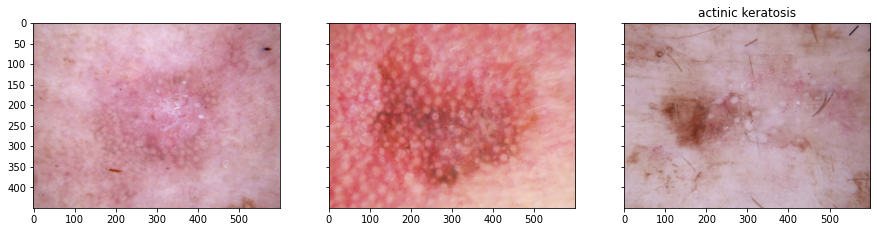

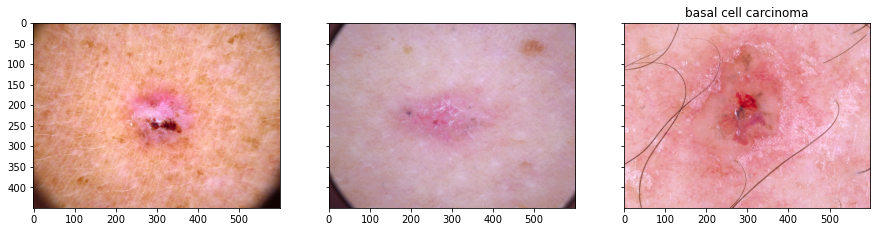

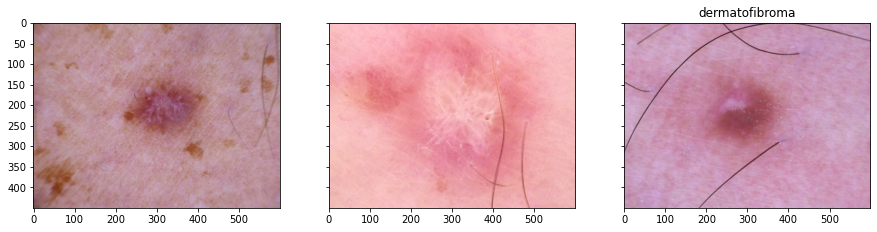

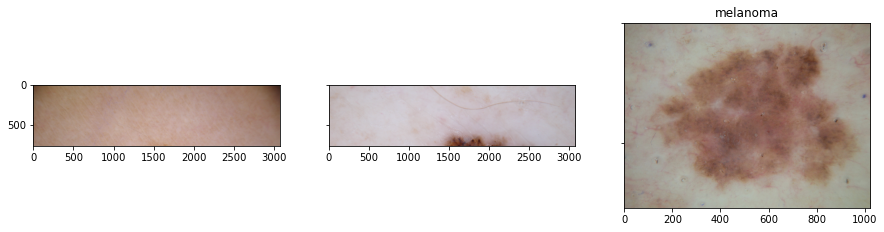

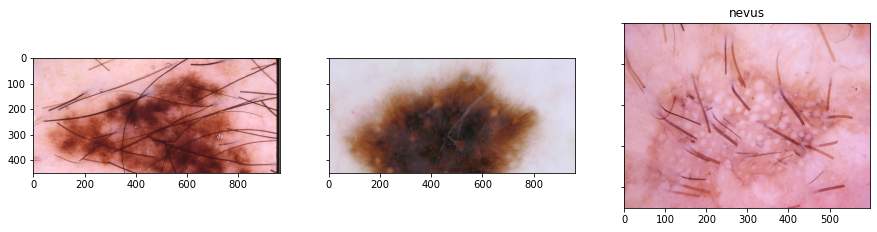

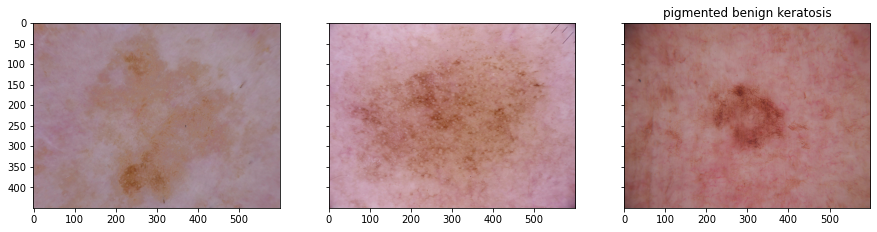

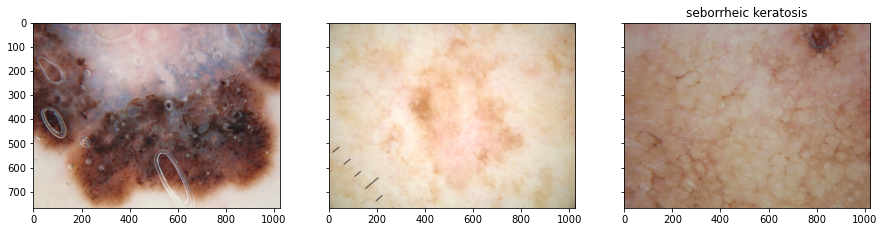

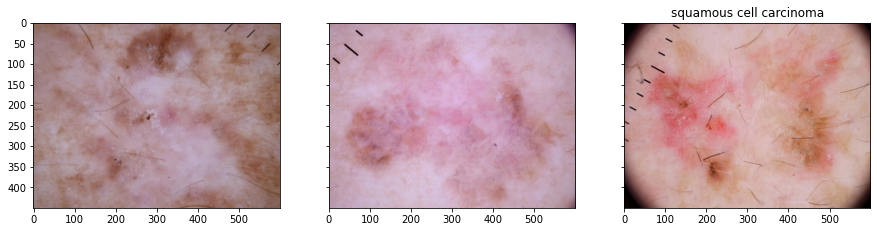

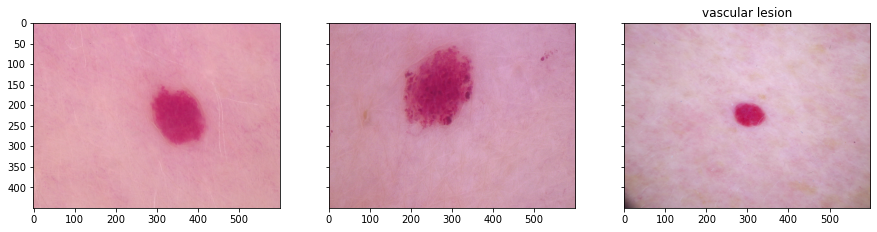

In [7]:
# Calling "starting" function for plotting 
starting(dataset_path, cancer_classes)

In [4]:
import PIL
from PIL import Image

In [5]:
# Parameters
batch_size=32
img_height = 180
img_width = 180

In [35]:
directory = "train/"
train_ds = tf.keras.utils.image_dataset_from_directory(
            directory,
            labels='inferred',
            label_mode='int',
            class_names=None,
            color_mode='rgb',
            batch_size=batch_size,
            image_size=(img_height, img_width),
            shuffle=True,
            seed=123,
            validation_split=0.2,
            subset='training',
            interpolation='bilinear',
            follow_links=False,
            crop_to_aspect_ratio=False)



Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [39]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [37]:
val_ds = tf.keras.utils.image_dataset_from_directory(
            directory,
            labels='inferred',
            label_mode='int',
            class_names=None,
            color_mode='rgb',
            batch_size=batch_size,
            image_size=(img_height, img_width),
            shuffle=True,
            seed=123,
            validation_split=0.2,
            subset='validation',
            interpolation='bilinear',
            follow_links=False,
            crop_to_aspect_ratio=False)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


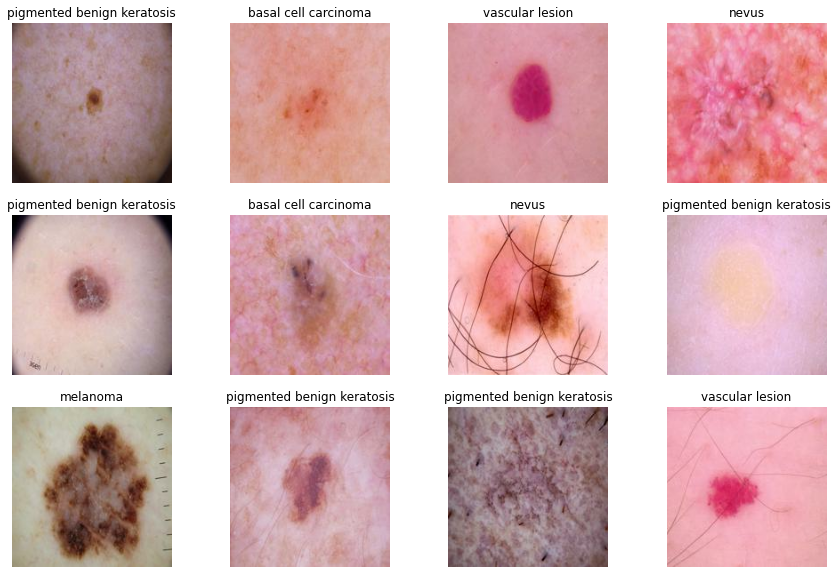

In [40]:
# Visualising the newly created dataset
plt.figure(figsize=(15,10))

for images,labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [42]:
for img,lab in val_ds:
    print(img.shape)
    print(lab.shape)
    break

(32, 180, 180, 3)
(32,)


In [43]:
# Using .cache() so as to prevent any possible blockage while training the model
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model-1 (BaseLineModelling)

In [44]:
# We have splitted the given training data into train_ds(80%) and val_ds(20%)

In [46]:
n_classes = len(class_names)

model = keras.Sequential([
        layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(16,(3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
    
        layers.Conv2D(32,(3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
    
        layers.Conv2D(64,(3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
    
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_3 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4

In [53]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [54]:
# Activating GPU for training the model
import time
start_time=time.time() 
with tf.device('/GPU:0'):
    epochs=16
    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=epochs)
print("\n TIME TAKEN: ",(time.time()-start_time), " seconds.")

Epoch 1/16
56/56 [==============================] - 44s 552ms/step - loss: 8.6762 - accuracy: 0.2796 - val_loss: 12.4808 - val_accuracy: 0.1499
Epoch 2/16
56/56 [==============================] - 27s 491ms/step - loss: 2.9570 - accuracy: 0.3214 - val_loss: 12.3243 - val_accuracy: 0.1499
Epoch 3/16
56/56 [==============================] - 24s 428ms/step - loss: 1.9916 - accuracy: 0.3343 - val_loss: 11.8866 - val_accuracy: 0.1499
Epoch 4/16
56/56 [==============================] - 27s 492ms/step - loss: 1.7210 - accuracy: 0.4102 - val_loss: 7.4246 - val_accuracy: 0.1499
Epoch 5/16
56/56 [==============================] - 29s 525ms/step - loss: 1.6943 - accuracy: 0.4174 - val_loss: 6.5922 - val_accuracy: 0.1499
Epoch 6/16
56/56 [==============================] - 24s 435ms/step - loss: 1.6184 - accuracy: 0.4269 - val_loss: 5.5860 - val_accuracy: 0.1790
Epoch 7/16
56/56 [==============================] - 26s 456ms/step - loss: 1.5580 - accuracy: 0.4609 - val_loss: 5.7429 - val_accuracy: 0.2

# Visualising Training Results

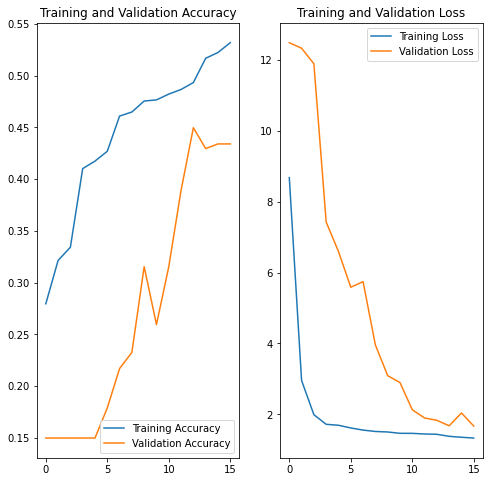

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

FINDINGS FOR MODEL-1 :- 
    Train accuracy is : 53%
    Validation accuracy is : 43%
Hence, our baseline model is clearly underfitting.
P.S: GPU speedboost to the process is amazing.

# Model-2 
### (Using Model-1 + Data Augmentation Layer)


In [68]:
# Defining an augmentation layer to fix underfitting
augmentation = keras.Sequential([
                layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                layers.experimental.preprocessing.RandomRotation(0.2),
                ])
# Using only randomflip, randomrotation, randomzoom because they are valid for the given dataset

In [72]:
n_classes = len(class_names)

model = keras.Sequential([
        layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)),
        #Adding augmentation layer to model_1
        augmentation,
    
        layers.Conv2D(16,(3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
    
        layers.Conv2D(32,(3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
    
        layers.Conv2D(64,(3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
    
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_4 (Sequential)   multiple                  0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_12 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 90, 90, 16)       

In [73]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [74]:
# Now running for 18 epochs
start_time=time.time() 
with tf.device('/GPU:0'):
    epochs=18
    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=epochs)
print("\n TIME TAKEN: ",(time.time()-start_time), " seconds.")

Epoch 1/18
56/56 [==============================] - 35s 557ms/step - loss: 8.1313 - accuracy: 0.2517 - val_loss: 12.9530 - val_accuracy: 0.2058
Epoch 2/18
56/56 [==============================] - 31s 548ms/step - loss: 2.1289 - accuracy: 0.3214 - val_loss: 13.2629 - val_accuracy: 0.2058
Epoch 3/18
56/56 [==============================] - 32s 566ms/step - loss: 1.8104 - accuracy: 0.3544 - val_loss: 8.4683 - val_accuracy: 0.2058
Epoch 4/18
56/56 [==============================] - 31s 561ms/step - loss: 1.7231 - accuracy: 0.3990 - val_loss: 9.4543 - val_accuracy: 0.0537
Epoch 5/18
56/56 [==============================] - 31s 561ms/step - loss: 1.6857 - accuracy: 0.4102 - val_loss: 7.4208 - val_accuracy: 0.1499
Epoch 6/18
56/56 [==============================] - 32s 569ms/step - loss: 1.6350 - accuracy: 0.4358 - val_loss: 4.9603 - val_accuracy: 0.1678
Epoch 7/18
56/56 [==============================] - 32s 568ms/step - loss: 1.6069 - accuracy: 0.4330 - val_loss: 3.9889 - val_accuracy: 0.17

# Visualising Results

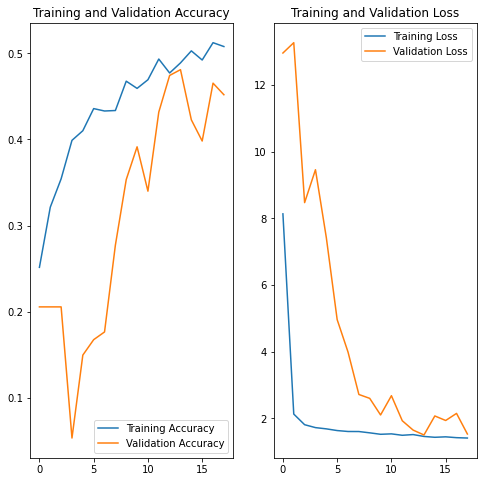

In [75]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model-2 :-
    Train accuracy : 50%
    Validation accuracy : 45%
The train accuracy has gone down but at the positive side the validation accuracy has gone up as compared to Model-1

In [98]:
# Checking Class Imbalance In Training Set
count = np.zeros(n_classes, dtype=np.int32)
for _, labels in train_ds:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()
#print(count)

for x,z in zip(cancer_classes, count):
    print(x,":",z,"-",round((z/1792)*100,2),"%")

actinic keratosis : 92 - 5.13 %
basal cell carcinoma : 309 - 17.24 %
dermatofibroma : 77 - 4.3 %
melanoma : 352 - 19.64 %
nevus : 277 - 15.46 %
pigmented benign keratosis : 370 - 20.65 %
seborrheic keratosis : 58 - 3.24 %
squamous cell carcinoma : 142 - 7.92 %
vascular lesion : 115 - 6.42 %


In [97]:
# Checking Class Imbalance In Validation Set
count = np.zeros(n_classes, dtype=np.int32)
for _, labels in val_ds:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()
#print(count)


for x,z in zip(cancer_classes, count):
    print(x,":",z,"-",round((z/447)*100,2),"%")

actinic keratosis : 22 - 4.92 %
basal cell carcinoma : 67 - 14.99 %
dermatofibroma : 18 - 4.03 %
melanoma : 86 - 19.24 %
nevus : 80 - 17.9 %
pigmented benign keratosis : 92 - 20.58 %
seborrheic keratosis : 19 - 4.25 %
squamous cell carcinoma : 39 - 8.72 %
vascular lesion : 24 - 5.37 %


Hence,
In Training set:
    Class with least number of samples => seborrheic keratosis 
    Dominant class (proportionatly) => pigmented benign keratosis
In Validation set:
    Class with least number of samples => dermatofibroma
    Dominant class (proportionatly) => pigmented benign keratosis

# Model-3
### (Model-1 + Augmentor)

In [99]:
!pip install Augmentor

In [6]:
import pathlib
from glob import glob

In [7]:
data_dir_train = pathlib.Path("Train")

In [8]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [9]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0aa394c3-4131-47d1-aaeb-3abf62761986.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2ae8c762-2559-4955-8b7c-fb8062889f48.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_55ee35ae-23c8-4ac5-bb21-cce6424953df.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_5aee5ad8-47c5-4a99-867a-6b8b375e2569.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6aae7cf6-a29b-465f-910e-4345961b02b5.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7e4e926d-908e-4b36-829d-90e252162a6d.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7faf71c7-515e-4a81-bf0e-f8bac301ea59.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_bd01bc8d-6f20-4714-8055-a1d6d9a20105.jpg',
 'Train\\actinic

In [10]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [11]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))


In [12]:
import pandas as pd

In [13]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2

,Path,Label
0,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
1,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
2,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
3,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
4,Train\actinic keratosis\output\actinic keratos...,actinic keratosis
...,...,...
4495,Train\vascular lesion\output\vascular lesion_o...,vascular lesion
4496,Train\vascular lesion\output\vascular lesion_o...,vascular lesion
4497,Train\vascular lesion\output\vascular lesion_o...,vascular lesion
4498,Train\vascular lesion\output\vascular lesion_o...,vascular lesion


In [22]:
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

In [14]:
directory = "train/"
train_ds = tf.keras.utils.image_dataset_from_directory(
            directory,
            labels='inferred',
            label_mode='int',
            class_names=None,
            color_mode='rgb',
            batch_size=batch_size,
            image_size=(img_height, img_width),
            shuffle=True,
            seed=123,
            validation_split=0.2,
            subset='training',
            interpolation='bilinear',
            follow_links=False,
            crop_to_aspect_ratio=False)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
            directory,
            labels='inferred',
            label_mode='int',
            class_names=None,
            color_mode='rgb',
            batch_size=batch_size,
            image_size=(img_height, img_width),
            shuffle=True,
            seed=123,
            validation_split=0.2,
            subset='validation',
            interpolation='bilinear',
            follow_links=False,
            crop_to_aspect_ratio=False)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [16]:
class_names = train_ds.class_names
n_classes = len(class_names)

model = keras.Sequential([
        layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)),
    
        layers.Conv2D(16,(3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
    
        layers.Conv2D(32,(3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
    
        layers.Conv2D(64,(3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
    
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4

In [17]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [19]:
import time

In [20]:
# Running on 22 epochs
start_time=time.time() 
with tf.device('/GPU:0'):
    epochs=22
    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=epochs)
print("\n TIME TAKEN: ",(time.time()-start_time), " seconds.")

Epoch 1/22
169/169 [==============================] - 77s 393ms/step - loss: 4.2698 - accuracy: 0.2619 - val_loss: 4.5278 - val_accuracy: 0.1425
Epoch 2/22
169/169 [==============================] - 62s 363ms/step - loss: 1.7683 - accuracy: 0.3513 - val_loss: 4.6900 - val_accuracy: 0.1581
Epoch 3/22
169/169 [==============================] - 64s 376ms/step - loss: 1.6241 - accuracy: 0.3897 - val_loss: 4.4414 - val_accuracy: 0.2368
Epoch 4/22
169/169 [==============================] - 64s 377ms/step - loss: 1.5539 - accuracy: 0.4164 - val_loss: 1.9916 - val_accuracy: 0.4001
Epoch 5/22
169/169 [==============================] - 60s 354ms/step - loss: 1.4858 - accuracy: 0.4347 - val_loss: 1.8458 - val_accuracy: 0.3014
Epoch 6/22
169/169 [==============================] - 62s 363ms/step - loss: 1.4593 - accuracy: 0.4447 - val_loss: 1.9536 - val_accuracy: 0.3586
Epoch 7/22
169/169 [==============================] - 61s 362ms/step - loss: 1.3663 - accuracy: 0.4787 - val_loss: 1.5248 - val_ac

# Visualising Results

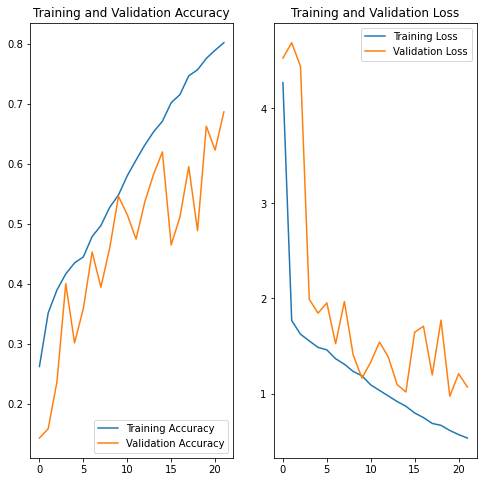

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model-3: 
    Training Accuracy: 53%
    Validation Accuracy: 68%
Now, the validation accuracy has shooted up to 68%, which is a great indication.
As, our model is doing better job in predicting unseen data.

Hence, we can conclude that the class rebalanced helped our model greatly.